In [1]:
import frites
import time
from   tqdm                import tqdm
import cupy                               as cp
import cupyx                              as cpx
import numpy                              as np
import matplotlib.pyplot                  as plt 
import scipy                              as sp
from   cupyx.scipy.special import digamma as psi

In [2]:
def nd_reshape(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = np.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., np.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = np.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = np.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def mi_model_nd_gd(x, y, mvaxis=None, traxis=-1, biascorrect=True,
                   demeaned=False, shape_checking=True):
    """Multi-dimentional MI between a Gaussian and a discret variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y : array_like
        Arrays to consider for computing the Mutual Information. The two input
        variables x and y should have the same shape except on the mvaxis
        (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x and y, without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape(x, mvaxis=mvaxis, traxis=traxis)
    assert isinstance(y, np.ndarray) and (y.ndim == 1)
    assert x.shape[-1] == len(y)

    # x.shape (..., x_mvaxis, traxis)
    nvarx, ntrl = x.shape[-2], x.shape[-1]
    u_y = np.unique(y)
    sh = x.shape[:-2]
    zm_shape = list(sh) + [len(u_y)]

    # joint variable along the mvaxis
    if not demeaned:
        x = x - x.mean(axis=-1, keepdims=True)

    # class-conditional entropies
    ntrl_y = np.zeros((len(u_y),), dtype=int)
    hcond = np.zeros(zm_shape, dtype=float)
    # c = .5 * (np.log(2. * np.pi) + 1)
    for num, yi in enumerate(u_y):
        idx = y == yi
        xm = x[..., idx]
        ntrl_y[num] = idx.sum()
        xm = xm - xm.mean(axis=-1, keepdims=True)
        cm = np.einsum('...ij, ...kj->...ik', xm, xm) / float(ntrl_y[num] - 1.)
        chcm = np.linalg.cholesky(cm)
        hcond[..., num] = np.log(np.einsum('...ii->...i', chcm)).sum(-1)

    # class weights
    w = ntrl_y / float(ntrl)

    # unconditional entropy from unconditional Gaussian fit
    cx = np.einsum('...ij, ...kj->...ik', x, x) / float(ntrl - 1.)
    chc = np.linalg.cholesky(cx)
    hunc = np.log(np.einsum('...ii->...i', chc)).sum(-1)

    ln2 = np.log(2)
    if biascorrect:
        vars = np.arange(1, nvarx + 1)

        psiterms = sp.special.psi((ntrl - vars).astype(float) / 2.) / 2.
        dterm = (ln2 - np.log(float(ntrl - 1))) / 2.
        hunc = hunc - nvarx * dterm - psiterms.sum()

        dterm = (ln2 - np.log((ntrl_y - 1).astype(float))) / 2.
        psiterms = np.zeros_like(ntrl_y, dtype=float)
        for vi in vars:
            idx = ntrl_y - vi
            psiterms = psiterms + sp.special.psi(idx.astype(np.float) / 2.)
        hcond = hcond - nvarx * dterm - (psiterms / 2.)

    # MI in bits
    i = (hunc - np.einsum('i, ...i', w, hcond)) / ln2
    return i

In [3]:
def nd_reshape_gpu(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = cp.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., cp.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = cp.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = cp.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def mi_model_nd_gd_gpu(x, y, mvaxis=None, traxis=-1, biascorrect=True,
                   demeaned=False, shape_checking=True):
    """Multi-dimentional MI between a Gaussian and a discret variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y : array_like
        Arrays to consider for computing the Mutual Information. The two input
        variables x and y should have the same shape except on the mvaxis
        (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x and y, without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape_gpu(x, mvaxis=mvaxis, traxis=traxis)
    assert isinstance(y, cp.ndarray) and (y.ndim == 1)
    assert x.shape[-1] == len(y)

    # x.shape (..., x_mvaxis, traxis)
    nvarx, ntrl = x.shape[-2], x.shape[-1]
    u_y = cp.unique(y)
    sh = x.shape[:-2]
    zm_shape = list(sh) + [len(u_y)]

    # joint variable along the mvaxis
    if not demeaned:
        x = x - x.mean(axis=-1, keepdims=True)

    # class-conditional entropies
    ntrl_y = cp.zeros((len(u_y),), dtype=int)
    hcond = cp.zeros(zm_shape, dtype=float)
    # c = .5 * (np.log(2. * np.pi) + 1)
    for num, yi in enumerate(u_y):
        idx = y == yi
        xm = x[..., idx]
        ntrl_y[num] = idx.sum()
        xm = xm - xm.mean(axis=-1, keepdims=True)
        cm = cp.einsum('...ij, ...kj->...ik', xm, xm) / float(ntrl_y[num] - 1.)
        chcm = cp.linalg.cholesky(cm)
        hcond[..., num] = cp.log(cp.einsum('...ii->...i', chcm)).sum(-1)

    # class weights
    w = ntrl_y / float(ntrl)

    # unconditional entropy from unconditional Gaussian fit
    cx = cp.einsum('...ij, ...kj->...ik', x, x) / float(ntrl - 1.)
    chc = cp.linalg.cholesky(cx)
    hunc = cp.log(cp.einsum('...ii->...i', chc)).sum(-1)

    ln2 = cp.log(2)
    if biascorrect:
        vars = cp.arange(1, nvarx + 1)

        psiterms = psi((ntrl - vars).astype(float) / 2.) / 2.
        dterm = (ln2 - cp.log(float(ntrl - 1))) / 2.
        hunc = hunc - nvarx * dterm - psiterms.sum()

        dterm = (ln2 - cp.log((ntrl_y - 1).astype(float))) / 2.
        psiterms = cp.zeros_like(ntrl_y, dtype=float)
        for vi in vars:
            idx = ntrl_y - vi
            psiterms = psiterms + psi(idx.astype(cp.float) / 2.)
        hcond = hcond - nvarx * dterm - (psiterms / 2.)

    # MI in bits
    i = (hunc - cp.einsum('i, ...i', w, hcond)) / ln2
    # Clean GPU memory
    cp._default_memory_pool.free_all_blocks()
    return i

In [4]:
# Generating coupled gaussian variables
def return_coupled_normal(Trials = 1, Regions = 10, N = 1000, rho = 0.7):
    x = np.random.normal(0, rho, size=(Trials, Regions, N))
    y = np.random.randint(0, 10, size=(N))
    return x,y

In [5]:
x,y = return_coupled_normal(Trials = 10, Regions = 10, N = 1000, rho = 0.7)

In [6]:
mi_model_nd_gd(x, y, mvaxis=1, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=False)

array([-0.03657354, -0.00800223,  0.0179273 , -0.04231583,  0.0146169 ,
        0.01223157,  0.03249995, -0.02575951,  0.02067099,  0.01322129])

In [7]:
x_gpu, y_gpu = cp.array(x), cp.array(y)
mi_model_nd_gd_gpu(x_gpu, y_gpu, mvaxis=1, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=False)

array([-0.03657354, -0.00800223,  0.0179273 , -0.04231583,  0.0146169 ,
        0.01223157,  0.03249995, -0.02575951,  0.02067099,  0.01322129])

In [12]:
# Computing for different series length
N_arr = np.linspace(1000, 100000, 20, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [15]:
for i in tqdm( range(N_arr.shape[-1]) ):
    x, y  = return_coupled_normal(Trials = 10, Regions = 10, N = N_arr[i], rho = 0.7)
    # CPU
    #start = time.time()
    aux = %timeit -o mi_model_nd_gd(x,y, mvaxis=1, traxis=-1, biascorrect=True, demeaned=False, shape_checking=False)
    #end   = time.time()
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu = cp.array(x), cp.array(y)
    #start = time.time()
    aux = %timeit -o mi_model_nd_gd_gpu(x_gpu,y_gpu, mvaxis=1, traxis=-1, biascorrect=True, demeaned=False, shape_checking=False)
    #end   = time.time()
    exta[1,i] = aux.average#end-start
    exts[1,i] = aux.stdev

  0%|          | 0/20 [00:00<?, ?it/s]

5.46 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


  5%|▌         | 1/20 [00:15<04:46, 15.09s/it]

12.9 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25 ms ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 10%|█         | 2/20 [00:28<04:22, 14.59s/it]

14 ms ± 8.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
46.6 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 15%|█▌        | 3/20 [00:45<04:21, 15.41s/it]

16.6 ms ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
69.8 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 20%|██        | 4/20 [01:06<04:32, 17.02s/it]

18.6 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
93.3 ms ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 25%|██▌       | 5/20 [01:16<03:41, 14.79s/it]

23.5 ms ± 87.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
114 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 30%|███       | 6/20 [01:27<03:13, 13.82s/it]

26.9 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
143 ms ± 643 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 35%|███▌      | 7/20 [01:41<03:00, 13.92s/it]

30.3 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
166 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 40%|████      | 8/20 [01:58<02:55, 14.61s/it]

32.3 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
191 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 45%|████▌     | 9/20 [02:16<02:53, 15.80s/it]

35.6 ms ± 61.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
221 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 50%|█████     | 10/20 [02:21<02:06, 12.61s/it]

38.9 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
247 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 55%|█████▌    | 11/20 [02:27<01:34, 10.53s/it]

42.2 ms ± 8.69 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
273 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 60%|██████    | 12/20 [02:33<01:13,  9.23s/it]

45.6 ms ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
299 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 65%|██████▌   | 13/20 [02:40<00:59,  8.47s/it]

48.8 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
322 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 70%|███████   | 14/20 [02:47<00:48,  8.07s/it]

52 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
351 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 75%|███████▌  | 15/20 [02:55<00:39,  7.96s/it]

55.5 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
369 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 80%|████████  | 16/20 [03:03<00:32,  8.08s/it]

61.8 ms ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
397 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 85%|████████▌ | 17/20 [03:12<00:24,  8.25s/it]

62 ms ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
421 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 90%|█████████ | 18/20 [03:21<00:17,  8.52s/it]

65.4 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
448 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


 95%|█████████▌| 19/20 [03:31<00:08,  8.86s/it]

68.7 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
469 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████| 20/20 [03:41<00:00, 11.07s/it]

75.7 ms ± 9.26 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


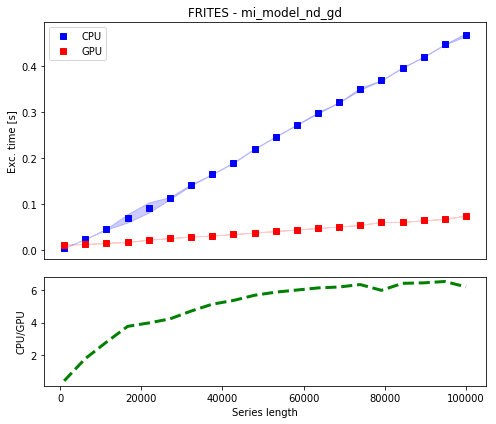

In [16]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - mi_model_nd_gd')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('mi_model_nd_gd.pdf', dpi = 600)